In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
import missingno as msno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import seaborn as sns
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from vecstack import StackingTransformer
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
pip install xgboost

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Data info

- **PassengerId** : 각 승객의 고유 번호
- **Survived** : 생존 여부 0 = No, 1 = Yes
- **Pclass** : 티켓의 승선권 클래스 (1 = 1st, 2 = 2nd, 3 = 3rd)
- **Name** : 이름
- **Sex** : 성별
- **Age** : 나이
- **SibSp** : 동반한 Sibling(형제자매)와 Spouse(배우자)의 수
- **Parch** : 동반한 Parent(부모) Child(자식)의 수
- **Ticket** : 티켓의 고유넘버
- **Fare** : 티켓의 요금
- **Cabin** : 객실 번호
- **Embarked** : 승선한 항 (C = Cherbourg, Q = Queenstown, S = Southampton)

<br>

## 1. Preparing dataset (2번부터 실습 진행)

In [3]:
data_df = pd.read_csv('titanic.csv')
data_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


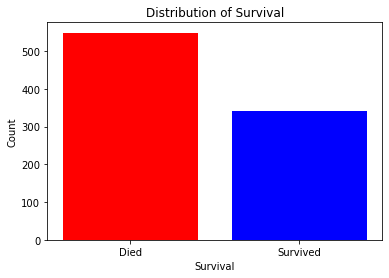

0    549
1    342
Name: Survived, dtype: int64

In [4]:
# 생존자와 사망자의 비율을 시각적으로 비교하는 막대 그래프
y_data = data_df[['Survived']]
survival_counts = y_data['Survived'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(survival_counts.index, survival_counts.values, color=['red', 'blue'])
plt.xticks([0, 1], ['Died', 'Survived'])
plt.xlabel('Survival')
plt.ylabel('Count')
plt.title('Distribution of Survival')
plt.show()

y_data['Survived'].value_counts()

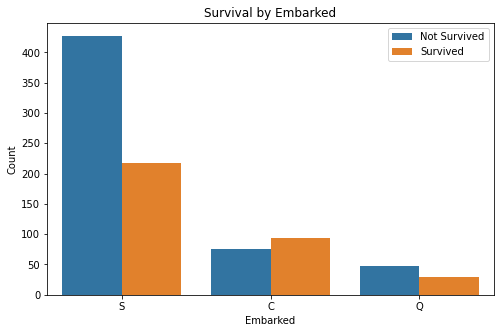

In [5]:
# 승선한 항에 따른 생존
# 막대그래프를 보았을 때 s승선항을 이용한 사람이 많음을 볼 수 있고,
# 승선한 항마다 생존율이 다름을 알 수 있습니다.
plt.figure(figsize=(8, 5))
sns.countplot(x='Embarked', hue='Survived', data=data_df)
plt.title('Survival by Embarked')
plt.xlabel('Embarked')
plt.ylabel('Count')
plt.legend(['Not Survived', 'Survived'], loc='upper right')
plt.show()

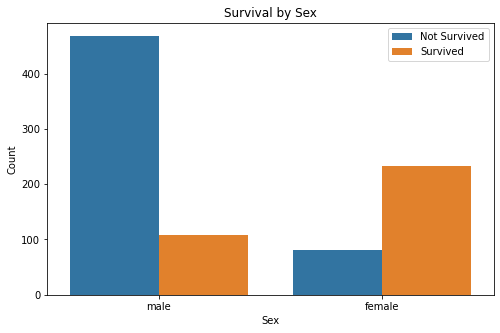

In [6]:
# 성별에 따른 생존
# 남성보다 여성이 더 많이 살아남음을 볼 수 있다.
plt.figure(figsize=(8, 5))
sns.countplot(x='Sex', hue='Survived', data=data_df)
plt.title('Survival by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(['Not Survived', 'Survived'], loc='upper right')
plt.show()

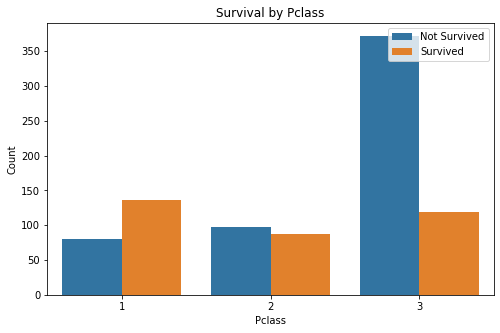

In [7]:
# 객실 등급에 따른 생존
# 등급이 올라갈 수록 생존율이 높아지는 것을 볼 수 있습니다.
plt.figure(figsize=(8, 5))
sns.countplot(x='Pclass', hue='Survived', data=data_df)
plt.title('Survival by Pclass')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.legend(['Not Survived', 'Survived'], loc='upper right')
plt.show()

In [8]:
# 깊은 복사
del data_df['Survived']
x_data = data_df.copy()
x_data.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


<br>

## 2. Feature engineering & Feature selection

#### 시도해볼 수 있는 전략들

- 불필요한 열이나 예측에 방해가 되는 열은 아예 지우기 (ex. PassengerId)
- 결측치 채우기 
- Text로 되어있는 Category(Factor)는 숫자로 바꿔주기 (ex. Male/Female -> 0/1)
- 실수 범위를 구간 범위로 바꿔주기 
- 필요한 경우 기존 열을 바탕으로 새로운 열을 계산해 추가하기

In [9]:
# 결측치가 있는 3가지열 (Age, Cabin, Embarked)
x_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


<AxesSubplot:>

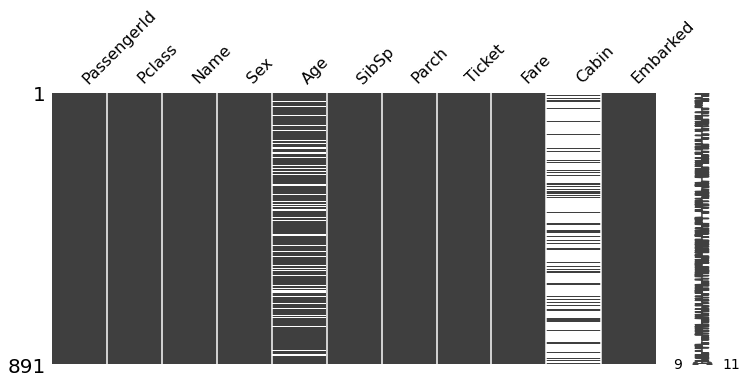

In [10]:
msno.matrix(x_data, figsize=(12,5))

In [11]:
# PassengerId : 각 승객의 고유 번호로 의미 없음
del x_data['PassengerId']
x_data = x_data.copy()
x_data.head(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [12]:
# 이름에서 호칭 추출하기
x_data['Name'] = x_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# 주요 호칭 그룹화
# 군인(Captain, Colonel, Major)이나 의사(Doctor), 목사(Reverend) 등과 같은 전문 직업
x_data['Name'] = x_data['Name'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer')
# 귀족(Royalty)이나 작위를 나타내는 호칭
x_data['Name'] = x_data['Name'].replace(['Jonkheer', 'Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty')
# 기혼 여성
x_data['Name'] = x_data['Name'].replace(['Mme', 'Ms', 'Mrs'], 'Mrs')
# 미혼 여성
x_data['Name'] = x_data['Name'].replace(['Mlle', 'Miss'], 'Miss')
# 기혼 남성
x_data['Name'] = x_data['Name'].replace(['Mr'], 'Mr')
# 미혼 남성
x_data['Name'] = x_data['Name'].replace(['Master'], 'Master')

In [13]:
# 성별에 따라 먼저 구조될 수도, 생존에 용이할 수 있을 듯하다.
encoder=LabelEncoder()
x_data['Sex']=encoder.fit_transform(x_data['Sex'])

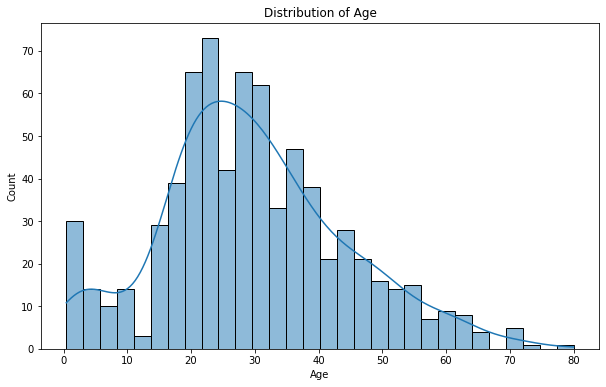

In [14]:
# Age 열의 분포 시각화
# 30개의 막대로 나누어서 보여주며, KDE 곡선을 함께 표시
plt.figure(figsize=(10, 6))
sns.histplot(x_data['Age'], bins=30, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# 데이터가 정규 분포를 따르지 않음.
x_data.loc[x_data['Age'].isnull(), 'Age'] = x_data['Age'].mean()

In [15]:
# SibSp : 동반한 Sibling(형제자매)와 Spouse(배우자)의 수 - 동반 여행자의 수에 따라 생존 차이가 있을 수도 있다.
# Parch : 동반한 Parent(부모) Child(자식)의 수 - 위와 동일
# SibSp와 Parch와 자신(1)을 결합하여 새로운 열 생성
x_data['FamilySize'] = x_data['SibSp'] + x_data['Parch'] + 1

# FamilySize열은 SibSp와 Parch열을 합친 값으로 중복된 정보를 포함하고, 불필요한 변수가 많으면 모델의 복잡성이 증가하여 과적합의 가능성을 높일 수 있다.
# SibSp와 Parch 열 삭제
x_data.drop(columns=['SibSp', 'Parch'], inplace=True)

In [16]:
# 티켓 번호에서 숫자 부분 추출하기
x_data['Ticket'] = x_data['Ticket'].apply(lambda x: ''.join(filter(str.isdigit, x)))
# Ticket열에서 분석에 필요한 정보를 찾지 못해서 제거함.
x_data.drop(columns=['Ticket'], inplace=True)

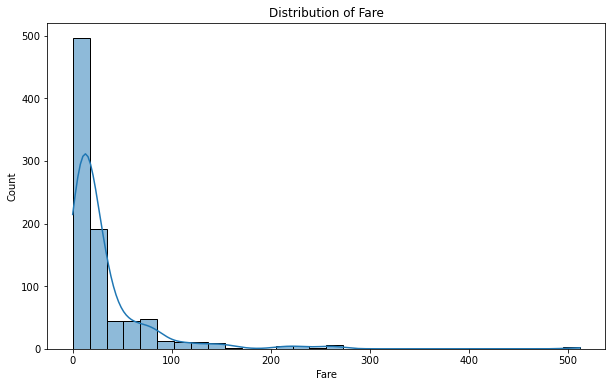

In [17]:
# Fare : 티켓의 요금 - 비싼 요금의 티켓과 생존 여부에 상관이 있을 수도 있다.
# 하지만 Pclass가 이 변수를 categorical하게 만든 변수가 아닐까?
# Fare 열의 분포 시각화
# 30개의 막대로 나누어서 보여주며, KDE 곡선을 함께 표시

plt.figure(figsize=(10, 6))
sns.histplot(x_data['Fare'], bins=30, kde=True)
plt.title('Distribution of Fare')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.show()

# 데이터가 정규 분포를 따르지 않음.

In [18]:
# Cabin : 객실 번호 - 어떤 객실 번호 범위는 좀 더 갑판 등의 생존에 용이한 위치에 있을 수도 있을 듯하다.
# 객실 알파벳 부분 추출하여 새로운 변수 생성
x_data['Cabin'] = x_data['Cabin'].str[0]

# x_data.Cabin.unique()
# Cabin 열에 있는 각 유니크한 값들을 확인해보니 N은 없었음.
# 결측치 처리: 객실 알파벳이 없는 경우 'N(Unknown)'으로 처리
x_data['Cabin'].fillna('N', inplace=True)

# 인터넷으로 타이타닉 구조를 검색한 후 pclass와 타이타닉의 층수를 기준으로 나눔.
# Cabin의 위치에 따라 등급을 나눔 예)A,B,C,D,T 는 1등급
cabin_mapping = {
    'A': 1, 'B': 1, 'C': 1, 'D': 1, 'T': 1,
    'E': 2, 'F': 2, 'G': 2,
    'N': 3  # Unknown 처리
}
x_data['Cabin'] = x_data['Cabin'].map(cabin_mapping)

In [19]:
# Embarked : 탑승지, C = 셰르부르, Q = 퀸즈타운, S = 사우샘프턴
# 결측치 처리(최빈값으로 대체)
most_common = x_data['Embarked'].mode()[0]
x_data['Embarked'].fillna(most_common, inplace=True)

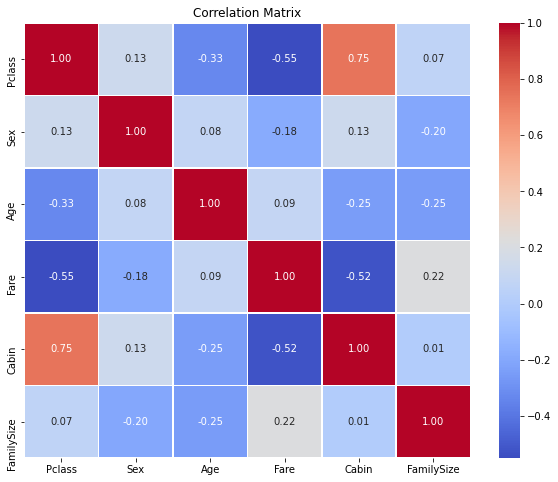

In [20]:
# 특성간 상관 관계 시각화: 데이터프레임의 특성들 간의 상관 관계를 히트맵으로 시각화하여 각 특성이 다른 특성들과 어떤 관계를 가지는지 확인
plt.figure(figsize=(10, 8))
correlation_matrix = x_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

<br>

## 3. Train - Test split (비율을 7:3 으로 유지해주시고, seed는 0을 적용해주세요)

In [21]:
# Train - Test split
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=0)
print("Train set:")
print(X_train.shape)
print("Test set:")
print(X_test.shape)
print("Train set:")
print(y_train.shape)
print("Test set:")
print(y_test.shape)

Train set:
(623, 8)
Test set:
(268, 8)
Train set:
(623, 1)
Test set:
(268, 1)


In [22]:
# 변수가 다른 변수들과 스케일이 달라서 영향을 많이 받아 학습이 제대로 이루어지지 않을 수 있어서 정규화 수행.
# 이상치에 민감하지 않도록 MinMaxScaler를 사용하여 정규화.

# Pipeline 정의
# 수치형 변수의 전처리
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# 범주형 변수의 전처리
categorical_transformer = Pipeline(steps=[

    # 만약 학습할 때는 있지만 테스트 데이터에서 새로운 범주가 발생할 경우
    # handle_unknown='ignore' 옵션을 통해 이를 무시하고 변환 작업을 진행
    # 이 옵션을 사용함으로써 모델이 학습할 때와 테스트할 때의 일관성을 유지하면서 처리할 수 있음.
    # (이름, 변환기)
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 전체 전처리 파이프라인 정의
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['Age', 'FamilySize', 'Fare']),  # 수치형 변수
        ('cat', categorical_transformer, ['Pclass', 'Name', 'Sex', 'Cabin', 'Embarked'])  # 범주형 변수
    ])

# 최종 Pipeline 정의 (전처리 + 모델)
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Train 데이터에 대해서만 fit을 적용
pipeline.fit(X_train)

# Train 데이터와 Test 데이터 각각에 대해 transform 수행
X_train = pipeline.transform(X_train)
X_test = pipeline.transform(X_test)

# 컬럼명 재구성
# 수치형 변수와 범주형 변수의 컬럼명을 다시 가져오기
numeric_features = preprocessor.transformers_[0][2]
categorical_features = preprocessor.transformers_[1][1]['onehot'].get_feature_names(['Pclass', 'Name', 'Sex', 'Cabin', 'Embarked'])

# 전체 특성의 컬럼명 재구성
feature_names = list(numeric_features) + list(categorical_features)

X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [23]:
# # 편리한 재정렬을 위해 기존의 인덱스를 일반 열로 변환합니다.
# X_train = X_train.reset_index()
# X_test = X_test.reset_index()

# # 훈련 데이터에서 Age 열의 결측치가 있는 행과 없는 행을 분리합니다.
# X_train_age_null = X_train[X_train['Age'].isnull()]
# X_train_age_notnull = X_train[X_train['Age'].notnull()]

# # Age 열이 결측치가 없는 행들로 train_x, train_y 설정
# train_x = X_train_age_notnull.drop(columns=['index', 'Age','Cabin','Embarked'])
# train_y = X_train_age_notnull['Age']

# # Age 열이 결측치가 있는 행들로 test_x 설정
# test_x = X_train_age_null.drop(columns=['index', 'Age','Cabin','Embarked'])

# # train 데이터를 사용하여 Age를 예측하는 머신러닝 모델을 학습시킵니다.
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV

# rf = RandomForestRegressor()

# rf.fit(train_x, train_y)

# # 학습된 모델을 사용하여 결측치가 있는 행들의 Age를 예측합니다.
# predicted_age = rf.predict(test_x)

# # 예측된 Age 값으로 결측치가 있는 행의 Age 열을 채웁니다.
# X_train.loc[X_train['Age'].isnull(), 'Age'] = predicted_age

# # 재정렬 후 기존 index 열을 삭제하여 인덱스를 정리합니다.
# X_train = X_train.sort_values(by='index').drop('index',axis=1)

In [24]:
# # 훈련 데이터에서 Age 열의 결측치가 있는 행과 없는 행을 분리합니다.
# X_test_age_null = X_test[X_test['Age'].isnull()]
# X_test_age_notnull = X_test[X_test['Age'].notnull()]

# # Age 열이 결측치가 없는 행들로 train_x, train_y 설정
# train_x = X_test_age_notnull.drop(columns=['index', 'Age','Cabin','Embarked'])
# train_y = X_test_age_notnull['Age']

# # Age 열이 결측치가 있는 행들로 test_x 설정
# test_x = X_test_age_null.drop(columns=['index', 'Age','Cabin','Embarked'])

# # train 데이터를 사용하여 Age를 예측하는 머신러닝 모델을 학습시킵니다.
# from sklearn.ensemble import RandomForestRegressor

# rf = RandomForestRegressor()
# rf.fit(train_x, train_y)

# # 학습된 모델을 사용하여 결측치가 있는 행들의 Age를 예측합니다.
# predicted_age = rf.predict(test_x)

# # 예측된 Age 값으로 결측치가 있는 행의 Age 열을 채웁니다.
# X_test.loc[X_test['Age'].isnull(), 'Age'] = predicted_age

# # 재정렬 후 기존 index 열을 삭제하여 인덱스를 정리합니다.
# X_test = X_test.sort_values(by='index').drop('index',axis=1)
# X_test

In [25]:
pd.DataFrame(X_train)

,Age,FamilySize,Fare,Pclass_1,Pclass_2,Pclass_3,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Name_Officer,Name_Royalty,Sex_0,Sex_1,Cabin_1,Cabin_2,Cabin_3,Embarked_C,Embarked_Q,Embarked_S
0,0.634438,0.0,0.051822,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.609227,0.1,0.149765,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.004160,0.7,0.091543,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.672255,0.1,0.150855,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.365929,0.1,0.028221,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,0.483172,0.2,0.162314,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
619,0.231060,0.1,0.015330,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
620,0.365929,0.0,0.015094,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
621,0.445355,0.1,0.033963,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [26]:
# 생존자와 사망자의 비율이 비교적 불균형하지만, AUC점수 확인 결과 점수가 낮아짐. 과적합이 우려되어 사용하지 않음.
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

<br>

## 4. Create model instance variable (동시에 여러 모델을 다른 이름으로 만들 수 있습니다.)

RandomForestClassifier ROC-AUC Score: 0.8779
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       168
           1       0.79      0.70      0.74       100

    accuracy                           0.82       268
   macro avg       0.81      0.79      0.80       268
weighted avg       0.82      0.82      0.81       268



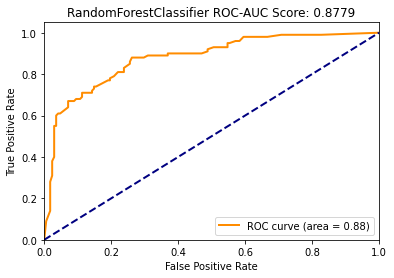

[22:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier ROC-AUC Score: 0.8701
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       168
           1       0.78      0.73      0.76       100

    accuracy                           0.82       268
   macro avg       0.82      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268



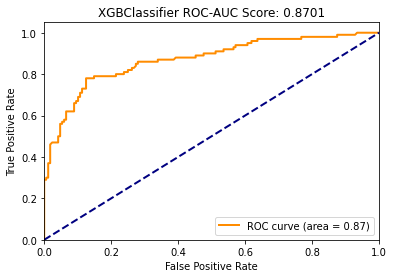

LogisticRegression ROC-AUC Score: 0.8718
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       168
           1       0.76      0.76      0.76       100

    accuracy                           0.82       268
   macro avg       0.81      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268



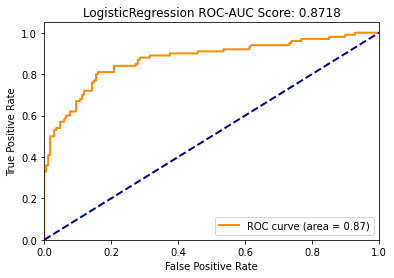

GradientBoostingClassifier ROC-AUC Score: 0.8814
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       168
           1       0.78      0.73      0.75       100

    accuracy                           0.82       268
   macro avg       0.81      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268



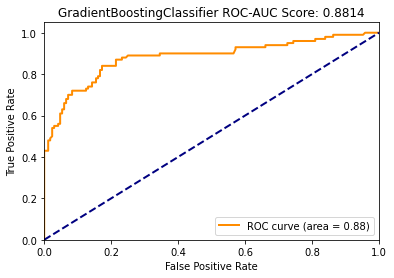

In [27]:
# 성능을 시각적으로 표현할 수 있는 auc score를 사용함.

# 전통적이고, 성능이 좋다고 알려진 모델들을 사용해봄.
models = {
    'RandomForestClassifier' : RandomForestClassifier(random_state=0),
    'XGBClassifier' : XGBClassifier(random_state=0),
    'LogisticRegression' : LogisticRegression(random_state=0),
    'GradientBoostingClassifier' : GradientBoostingClassifier(random_state=0)
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    
    # 클래스 1에 대한 예측 확률
    pred_proba = model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, pred_proba)
    print(f'{model_name} ROC-AUC Score: {roc_auc:.4f}')
    
    # 예측 결과와 실제 레이블을 이용하여 classification report 생성
    print(classification_report(y_test, pred))
    
    # ROC curve 및 AUC 계산
    fpr, tpr, _ = roc_curve(y_test, pred_proba)
    roc_auc = auc(fpr, tpr)

    # ROC curve 그리기
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title((f'{model_name} ROC-AUC Score: {roc_auc:.4f}'))
    plt.legend(loc="lower right")
    plt.show()

Fitting 5 folds for each of 100 candidates, totalling 500 fits
최적의 하이퍼파라미터: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 3, 'learning_rate': 0.1}
최적의 Gradient Boosting ROC-AUC 점수: 0.8680

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       168
           1       0.78      0.73      0.76       100

    accuracy                           0.82       268
   macro avg       0.82      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268



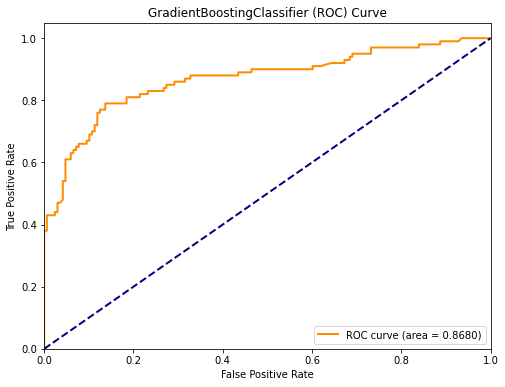

In [28]:
# 그리드서치를 사용해보았으나 느려서 랜덤 서치 사용함.
# 최적의 조합을 빠르게 찾고자 랜덤서치 사용함.
# 위의 모델 중 가장 성능이 좋은 GradientBoostingClassifier 모델 Hyper-parameter tuning 적용

# GradientBoostingClassifier 모델 생성
gb = GradientBoostingClassifier(random_state=0)

# 랜덤 서치를 위한 하이퍼파라미터 후보 설정
param = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# RandomizedSearchCV 객체 생성
random_search = RandomizedSearchCV(estimator=gb, param_distributions=param, n_iter=100,
                                   cv=5, scoring='roc_auc', random_state=0, verbose=1, n_jobs=-1)

# 랜덤 서치를 사용하여 모델 학습
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print(f"최적의 하이퍼파라미터: {random_search.best_params_}")

# 최적 모델로 예측
random_pred = random_search.predict(X_test)

# 최적 모델의 ROC-AUC 점수 계산
probs = random_search.predict_proba(X_test)[:, 1]
roc_auc_random = roc_auc_score(y_test, probs)
print(f'최적의 Gradient Boosting ROC-AUC 점수: {roc_auc_random:.4f}')
print()

# 예측 결과와 실제 레이블을 이용하여 classification report 생성
print(classification_report(y_test, random_pred))

# ROC 곡선 계산
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GradientBoostingClassifier (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

<br>

## 5. Train the model (Stacking)

In [29]:
# StackingTransformer에 사용될 모델 객체들을 ( ‘name’, ‘모델 종류’) 의 tuple형식을 사용한다.
estimators = [ 
    ('ExtraTrees', ExtraTreesClassifier(random_state = 0, n_jobs = -1, n_estimators = 100, max_depth = 3)),
    ('RandomForest', RandomForestClassifier(random_state = 0, n_jobs = -1, n_estimators = 100, max_depth = 3)),
    ('XGB', XGBClassifier(seed = 0, n_jobs = -1, learning_rate = 0.1, n_estimators = 100, max_depth = 3, eval_metric='mlogloss'))]

# StackingTransformer 를 만든다.
stack = StackingTransformer(estimators, 
                            regression = False, 
                            metric = roc_auc_score, 
                            n_folds = 4, stratified = True, shuffle = True, 
                            random_state = 0, verbose = 2) 

# StackingTransformer에 X_train, y_train을 이용해 학습한다.
# transform() 함수를 이용하여 변환한다.
# 이후에는 위의 2단계 stacking 기법과 같이 진행된다.
stack = stack.fit(X_train, y_train)

S_train = stack.transform(X_train)
S_test = stack.transform(X_test)

task:         [classification]
n_classes:    [2]
metric:       [roc_auc_score]
variant:      [A]
n_estimators: [3]

estimator  0: [ExtraTrees: ExtraTreesClassifier]
    fold  0:  [0.73080242]
    fold  1:  [0.82735116]
    fold  2:  [0.80625000]
    fold  3:  [0.74736842]
    ----
    MEAN:     [0.77794300] + [0.03999841]

estimator  1: [RandomForest: RandomForestClassifier]
    fold  0:  [0.76764452]
    fold  1:  [0.84314064]
    fold  2:  [0.81145833]
    fold  3:  [0.76315789]
    ----
    MEAN:     [0.79635035] + [0.03295203]

estimator  2: [XGB: XGBClassifier]
    fold  0:  [0.76238136]
    fold  1:  [0.84607420]
    fold  2:  [0.79270833]
    fold  3:  [0.79956140]
    ----
    MEAN:     [0.80018133] + [0.02996341]

Train set was detected.
Transforming...

estimator  0: [ExtraTrees: ExtraTreesClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  1: [RandomForest: RandomForestC

Final ROC-AUC Score: [0.81750000]

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       168
           1       0.78      0.76      0.77       100

    accuracy                           0.83       268
   macro avg       0.82      0.82      0.82       268
weighted avg       0.83      0.83      0.83       268



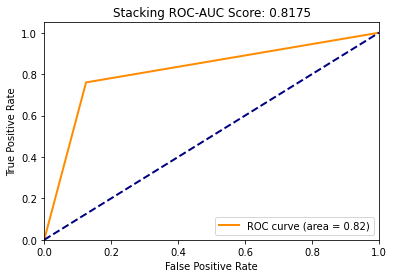

In [30]:
# 2단계 모델
model = GradientBoostingClassifier(random_state = 0, learning_rate = 0.1, n_estimators = 100, max_depth = 3) 

# 2단계 모델을 학습.
model = model.fit(S_train, y_train) 

# 학습된 2단계 모델을 가지고 예측한다.
y_pred = model.predict(S_test) 
print('Final ROC-AUC Score: [%.8f]' % roc_auc_score(y_test, y_pred))
print()

# 예측 결과와 실제 레이블을 이용하여 classification report 생성
print(classification_report(y_test, y_pred))

# ROC curve 및 AUC 계산
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# ROC curve 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title((f'Stacking ROC-AUC Score: {roc_auc:.4f}'))
plt.legend(loc="lower right")
plt.show()

현재 우리가 사용했던 모델 중에서는 그래디언트부스팅이 가장 성능이 높음을 알 수 있습니다.

스태킹 적용 결과 모델 성능이 더 낮아짐을 알 수 있다. (데이터의 수가 적어서 그럴 가능성 있음.)

<br>

## 6. 향후 보안할 점

age열의 결측치를 랜던포레스트와 그리드서치를 통해 채우려 하였으나, 성능이 안좋아져서 다른 열들을 수정해보았으나 성능은 변함이 없었고, 마지막으로 age 열의 결측치를 평균값으로 채웠더니 성능이 좋아졌다.

시간이 부족해서 더 찾아보지 못했지만 추후 결측치를 모델을 통해 채우면서 성능을 높일 수 있는 방법을 찾아봐야겠다.